In [1]:
# Import dependencies
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# Data Exploration:

In [2]:
# Save lockdown data to dataframe
lockdown_link = 'data/covid_lockdown.csv'
lockdown_data = pd.read_csv(lockdown_link)
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level
115,United States,New York,3/20/2020,5/15/2020,State
116,United States,Oregon,3/24/2020,NaN,State
117,United States,Wisconsin,3/24/2020,NaN,State
118,Venezuela,NaN,3/17/2020,5/13/2020,National
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National


In [3]:
# To make calculations easier, replace any TBD or NaN in 'End date' with today's date.
today = str(date.today())

lockdown_data['End date'] = lockdown_data['End date'].fillna(today)
lockdown_data['End date'] = lockdown_data['End date'].str.replace(pat = 'TBD', repl= today)

In [4]:
# Apply median incubation period (5 days) to lockdown start date in order to see effectiveness of lockdown
incubation_period = timedelta(days=5)
lockdown_data['Lock Effect Start'] = pd.to_datetime(lockdown_data['Start date']) + incubation_period
lockdown_data['Lock Effect End'] = pd.to_datetime(lockdown_data['End date']) + incubation_period
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
115,United States,New York,3/20/2020,5/15/2020,State,2020-03-25,2020-05-20
116,United States,Oregon,3/24/2020,2020-05-24,State,2020-03-29,2020-05-29
117,United States,Wisconsin,3/24/2020,2020-05-24,State,2020-03-29,2020-05-29
118,Venezuela,NaN,3/17/2020,5/13/2020,National,2020-03-22,2020-05-18
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National,2020-04-04,2020-05-07


In [5]:
# For countries that have more than one 'place', only keep the first entry
index = []
for country in range(1, len(lockdown_data['Countries and territories'])):
    if lockdown_data['Countries and territories'][country] == lockdown_data['Countries and territories'][country -1]:
        index.append(country)
lock_data = lockdown_data.drop(lockdown_data.index[index])
lock_data.head()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
0,Albania,NaN,3/13/2020,2020-05-24,National,2020-03-18,2020-05-29
1,Algeria,Algiers,3/23/2020,4/19/2020,City,2020-03-28,2020-04-24
3,Argentina,NaN,3/19/2020,5/10/2020,National,2020-03-24,2020-05-15
4,Armenia,NaN,3/24/2020,4/14/2020,National,2020-03-29,2020-04-19
5,Australia,NaN,3/23/2020,2020-05-24,National,2020-03-28,2020-05-29


In [6]:
# Make array of each country that experienced lockdown
lock_countries = lock_data['Countries and territories'].unique()
lock_countries

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belgium',
       'Bermuda', 'Bolivia', 'Botswana', 'Brazil', 'Chile', 'Colombia',
       'Republic of the Congo', 'Costa Rica', 'Croatia', 'Cuba',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Eritrea', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guernsey', 'Honduras', 'Hungary',
       'India', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Jordan',
       'Kosova', 'Kuwait', 'Lebanon', 'Liberia', 'Libya', 'Lithuania',
       'Luxembourg', 'Madagascar', 'Malaysia', 'Mongolia', 'Montenegro',
       'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand',
       'Nigeria', 'Northern Cyprus', 'Norway', 'Oman', 'Pakistan',
       'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda',
       'Samoa', 'Sa

In [7]:
# Pseudorandom sub_list from above countries: similar economic development in most
test_list = ['Australia', 'Austria', 'Finland', 'Germany', 'Ireland', 'Italy', 'Netherlands', 'Norway', 'Spain', 'Switzerland']
Test_limit = timedelta(days=14)     # upper time period to observe for each country
test_limit = timedelta(days=15)     # lower time period to observe for each country

In [8]:
# Save Worldwide Covid data to dataframe
cov_link = 'data/world_covid.csv'
cov_data = pd.read_csv(cov_link)
cov_data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,04/05/2020,4,5,2020,235,13,Afghanistan,AF,AFG,37172386.0,Asia
1,03/05/2020,3,5,2020,134,4,Afghanistan,AF,AFG,37172386.0,Asia
2,02/05/2020,2,5,2020,164,4,Afghanistan,AF,AFG,37172386.0,Asia
3,01/05/2020,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
4,30/04/2020,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia


In [9]:
# Make array of all countries and territories
all_countries = cov_data['countriesAndTerritories'].unique()
len(all_countries)

209

In [10]:
# Left merge dataframes keeping the world covid data in tact
left_merge = cov_data.merge(lock_data, how='left', left_on='countriesAndTerritories', right_on='Countries and territories')

In [11]:
# Drop unneeded columns
left_merge = left_merge[['countriesAndTerritories', 'dateRep', 'day', 'month', 'cases', 'deaths', 'popData2018', 'Lock Effect Start', 'Lock Effect End']]

# Create boolean lockdown column and set to false when 'lockdown effective' is NaN
left_merge['Lockdown'] = pd.notnull(left_merge['Lock Effect Start'])

# Sets datatype of dates to datetime
left_merge['dateRep'] = pd.to_datetime(left_merge['dateRep'], infer_datetime_format=True)
left_merge['Lock Effect End'] = pd.to_datetime(left_merge['Lock Effect End'], infer_datetime_format=True)


In [12]:
# Loop and conditional to replace boolean lockdown values if the lockdown date falls outside the lockdown effective period
for x in range(len(left_merge)):
    if (left_merge['Lockdown'][x] == True) & ((left_merge['dateRep'][x] < left_merge['Lock Effect Start'][x]) | (left_merge['dateRep'][x] > left_merge['Lock Effect End'][x])):
        left_merge.at[x, 'Lockdown'] = False

# Examine data        
left_merge.tail(50)

,countriesAndTerritories,dateRep,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown
14816,Zambia,2020-03-23,23,3,1,0,17351822.0,NaT,NaT,False
14817,Zambia,2020-03-22,22,3,0,0,17351822.0,NaT,NaT,False
14818,Zambia,2020-03-21,21,3,0,0,17351822.0,NaT,NaT,False
14819,Zambia,2020-03-20,20,3,0,0,17351822.0,NaT,NaT,False
14820,Zambia,2020-03-19,19,3,2,0,17351822.0,NaT,NaT,False
14821,Zimbabwe,2020-04-05,4,5,0,0,14439018.0,2020-04-04,2020-05-07,True
14822,Zimbabwe,2020-03-05,3,5,0,0,14439018.0,2020-04-04,2020-05-07,False
14823,Zimbabwe,2020-02-05,2,5,0,0,14439018.0,2020-04-04,2020-05-07,False
14824,Zimbabwe,2020-01-05,1,5,0,0,14439018.0,2020-04-04,2020-05-07,False
14825,Zimbabwe,2020-04-30,30,4,2,0,14439018.0,2020-04-04,2020-05-07,True


After looking at the data closer, it seems there is a data entry problem in the source code.

At one point it looks like they switched the day and month values in the dateRep column by mistake, thus giving some dates outside of months that have actually happened yet. The day and month columns seem to be in the correct order, so these can be used to fix the dates in dateRep

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


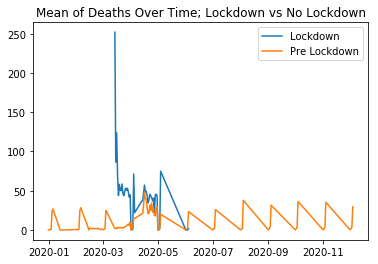

In [13]:
# Verify data entry problem with a graph
plt.plot(left_merge[left_merge['Lockdown'] == True].groupby(['dateRep'])['deaths'].mean(), label='Lockdown')
plt.plot(left_merge[left_merge['Lockdown'] == False].groupby(['dateRep'])['deaths'].mean(), label='Pre Lockdown')
plt.title('Mean of Deaths Over Time; Lockdown vs No Lockdown')
plt.legend()
plt.show()

Graph info isnt extremely meaningful since each country got infected at different points in time and went into lockdown
at different points in time, but the curious pattern and date range hints at a data entry error.
 
Closer inspection verifies all the countries are having the same data entry problem in the date where the month and day values seem to be switched, causing a lot of the data to be grouped in regular intervals at the end of the graph, outside of date ranges that have happened yet.

# Data Cleanup:

In [14]:
# Fix the date problem:

# Change dateRep datetime back to string
left_merge['dateRep'] = left_merge['dateRep'].dt.strftime('%Y-%m-%d')
left_merge.head()

,countriesAndTerritories,dateRep,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown
0,Afghanistan,2020-04-05,4,5,235,13,37172386.0,NaT,NaT,False
1,Afghanistan,2020-03-05,3,5,134,4,37172386.0,NaT,NaT,False
2,Afghanistan,2020-02-05,2,5,164,4,37172386.0,NaT,NaT,False
3,Afghanistan,2020-01-05,1,5,222,4,37172386.0,NaT,NaT,False
4,Afghanistan,2020-04-30,30,4,122,0,37172386.0,NaT,NaT,False


In [15]:
left_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14866 entries, 0 to 14865
Data columns (total 10 columns):
countriesAndTerritories    14866 non-null object
dateRep                    14866 non-null object
day                        14866 non-null int64
month                      14866 non-null int64
cases                      14866 non-null int64
deaths                     14866 non-null int64
popData2018                14710 non-null float64
Lock Effect Start          6765 non-null datetime64[ns]
Lock Effect End            6765 non-null datetime64[ns]
Lockdown                   14866 non-null bool
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 1.8+ MB


In [16]:
# Split dateRep into columns
temp = left_merge['dateRep'].str.split("-", expand = True)
left_merge['dateRep_year'] = temp[0]

In [17]:
left_merge.tail(28)

,countriesAndTerritories,dateRep,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown,dateRep_year
14838,Zimbabwe,2020-04-17,17,4,1,0,14439018.0,2020-04-04,2020-05-07,True,2020
14839,Zimbabwe,2020-04-16,16,4,6,0,14439018.0,2020-04-04,2020-05-07,True,2020
14840,Zimbabwe,2020-04-15,15,4,0,0,14439018.0,2020-04-04,2020-05-07,True,2020
14841,Zimbabwe,2020-04-14,14,4,3,0,14439018.0,2020-04-04,2020-05-07,True,2020
14842,Zimbabwe,2020-04-13,13,4,0,0,14439018.0,2020-04-04,2020-05-07,True,2020
14843,Zimbabwe,2020-12-04,12,4,3,0,14439018.0,2020-04-04,2020-05-07,False,2020
14844,Zimbabwe,2020-11-04,11,4,0,0,14439018.0,2020-04-04,2020-05-07,False,2020
14845,Zimbabwe,2020-10-04,10,4,0,1,14439018.0,2020-04-04,2020-05-07,False,2020
14846,Zimbabwe,2020-09-04,9,4,1,1,14439018.0,2020-04-04,2020-05-07,False,2020
14847,Zimbabwe,2020-08-04,8,4,1,0,14439018.0,2020-04-04,2020-05-07,False,2020


In [18]:
# Drop old dateRep column in preparation to replace it
left_merge.drop('dateRep', axis=1, inplace=True)

# Change day and month columns to strings
left_merge['day'] = left_merge['day'].apply(str)
left_merge['month'] = left_merge['month'].apply(str)

# Conditional to format month and day
for x in range(len(left_merge)):
    if int(left_merge['month'][x]) < 10:
        left_merge.at[x, 'month'] = ''.join(['0', left_merge.at[x, 'month']])
    if int(left_merge['day'][x]) < 10:
        left_merge.at[x, 'day'] = ''.join(['0', left_merge.at[x, 'day']])
            
            
# Combine columns into new dateRep column
left_merge['dateRep'] = left_merge[['dateRep_year', 'month', 'day']].agg('-'.join, axis=1)

# Set datatype of dateRep back to datetime
left_merge['dateRep'] = pd.to_datetime(left_merge['dateRep'], infer_datetime_format=True)

left_merge.tail(28)

,countriesAndTerritories,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown,dateRep_year,dateRep
14838,Zimbabwe,17,04,1,0,14439018.0,2020-04-04,2020-05-07,True,2020,2020-04-17
14839,Zimbabwe,16,04,6,0,14439018.0,2020-04-04,2020-05-07,True,2020,2020-04-16
14840,Zimbabwe,15,04,0,0,14439018.0,2020-04-04,2020-05-07,True,2020,2020-04-15
14841,Zimbabwe,14,04,3,0,14439018.0,2020-04-04,2020-05-07,True,2020,2020-04-14
14842,Zimbabwe,13,04,0,0,14439018.0,2020-04-04,2020-05-07,True,2020,2020-04-13
14843,Zimbabwe,12,04,3,0,14439018.0,2020-04-04,2020-05-07,False,2020,2020-04-12
14844,Zimbabwe,11,04,0,0,14439018.0,2020-04-04,2020-05-07,False,2020,2020-04-11
14845,Zimbabwe,10,04,0,1,14439018.0,2020-04-04,2020-05-07,False,2020,2020-04-10
14846,Zimbabwe,09,04,1,1,14439018.0,2020-04-04,2020-05-07,False,2020,2020-04-09
14847,Zimbabwe,08,04,1,0,14439018.0,2020-04-04,2020-05-07,False,2020,2020-04-08


In [19]:
test_data = left_merge[left_merge['countriesAndTerritories'].isin(test_list)]    # make dataframe of only countries of interest
test_data['Pre-Lock'] = test_data['Lock Effect Start'] - test_limit              # time period just before lockdown takes effect
test_data['Post-Lock'] = test_data['Lock Effect Start'] + Test_limit             # time period just after lockdown takes effect


# Limit date range to only the test period
test_data.reset_index(drop=True, inplace=True)
for x in range(len(test_data)):
    if (test_data['dateRep'][x] <= test_data['Pre-Lock'][x]) | (test_data['dateRep'][x] >= test_data['Post-Lock'][x]):
        test_data.drop(labels= x, axis = 0, inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [20]:
# Fix inaccurate lockdown values:

# Drop old Lockdown column in preparation to replace it
test_data.drop('Lockdown', axis=1, inplace=True)

# Reset index again after limiting dates outside of the test period
test_data.reset_index(drop=True, inplace=True)

# Recreate boolean lockdown column and set to false when 'lockdown effective' is NaN
test_data['Lockdown'] = pd.notnull(test_data['Lock Effect Start'])

# Loop and conditional to replace boolean lockdown values if the lockdown date falls outside the lockdown effective period
for x in range(len(test_data)):
    if (test_data['Lockdown'][x] == True) & ((test_data['dateRep'][x] < test_data['Lock Effect Start'][x]) | (test_data['dateRep'][x] > test_data['Lock Effect End'][x])):
        test_data.at[x, 'Lockdown'] = False

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [21]:
# This loop adds the value 'date count' to compare date ranges of each country against each other
count = 1
test_data['Date Count'] = count
test_data.sort_values(by=['countriesAndTerritories', 'dateRep'], inplace=True)
test_data.reset_index(drop=True, inplace=True)
for x in range(1, len(test_data)):
    if (test_data['countriesAndTerritories'][x] == test_data['countriesAndTerritories'][x -1]) & (test_data['Lockdown'][x] == test_data['Lockdown'][x -1]):
        count += 1
        test_data['Date Count'][x] = count
    else:
        count = 1
        test_data['Date Count'][x] = count
test_data.head(15)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,countriesAndTerritories,day,month,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,dateRep_year,dateRep,Pre-Lock,Post-Lock,Lockdown,Date Count
0,Australia,14,03,41,0,24992369.0,2020-03-28,2020-05-29,2020,2020-03-14,2020-03-13,2020-04-11,False,1
1,Australia,15,03,52,0,24992369.0,2020-03-28,2020-05-29,2020,2020-03-15,2020-03-13,2020-04-11,False,2
2,Australia,16,03,49,2,24992369.0,2020-03-28,2020-05-29,2020,2020-03-16,2020-03-13,2020-04-11,False,3
3,Australia,17,03,77,0,24992369.0,2020-03-28,2020-05-29,2020,2020-03-17,2020-03-13,2020-04-11,False,4
4,Australia,18,03,79,0,24992369.0,2020-03-28,2020-05-29,2020,2020-03-18,2020-03-13,2020-04-11,False,5
5,Australia,19,03,111,1,24992369.0,2020-03-28,2020-05-29,2020,2020-03-19,2020-03-13,2020-04-11,False,6
6,Australia,20,03,144,0,24992369.0,2020-03-28,2020-05-29,2020,2020-03-20,2020-03-13,2020-04-11,False,7
7,Australia,21,03,165,1,24992369.0,2020-03-28,2020-05-29,2020,2020-03-21,2020-03-13,2020-04-11,False,8
8,Australia,22,03,224,0,24992369.0,2020-03-28,2020-05-29,2020,2020-03-22,2020-03-13,2020-04-11,False,9
9,Australia,23,03,611,0,24992369.0,2020-03-28,2020-05-29,2020,2020-03-23,2020-03-13,2020-04-11,False,10


In [22]:
group_sum = test_data.groupby(['countriesAndTerritories', 'Lockdown'])[['cases', 'deaths']].sum()
group_sum

cases  deaths
countriesAndTerritories Lockdown               
Australia               False      3010      10
                        True       2986      39
Austria                 False      2155       6
                        True       8933     152
Finland                 False      1041      13
                        True       1751      46
Germany                 False     39919     248
                        True      71237    2120
Ireland                 False       168       2
                        True       2446      44
Italy                   False     14463     999
                        True      65426    7149
Netherlands             False      2378      76
                        True      12237    1263
Norway                  False      1058       1
                        True       3025      21
Spain                   False     11027     491
                        True      83239    7698
Switzerland             False      4631      42
                        True      14387     441

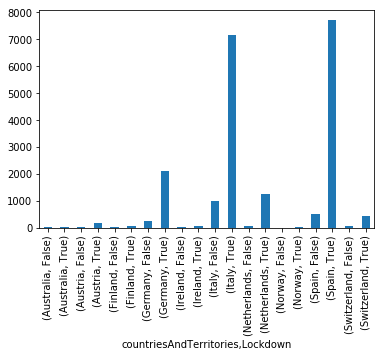

In [23]:
group_sum['deaths'].plot.bar()

Because of the exponential spread of the virus, it is difficult to tease out the trend of whether the lockdowns were effective  when looking only at the raw sum, even over a very similar period of time.

In [24]:
group_mean = test_data.groupby(['countriesAndTerritories', 'Lockdown']).mean()
group_mean

cases      deaths  popData2018  \
countriesAndTerritories Lockdown                                         
Australia               False      215.000000    0.714286   24992369.0   
                        True       213.285714    2.785714   24992369.0   
Austria                 False      153.928571    0.428571    8847037.0   
                        True       638.071429   10.857143    8847037.0   
Finland                 False       74.357143    0.928571    5518050.0   
                        True       125.071429    3.285714    5518050.0   
Germany                 False     2851.357143   17.714286   82927922.0   
                        True      5088.357143  151.428571   82927922.0   
Ireland                 False       14.000000    0.166667    4853506.0   
                        True       174.714286    3.142857    4853506.0   
Italy                   False     1033.071429   71.357143   60431283.0   
                        True      4673.285714  510.642857   60431283.0   
Netherlands             False      169.857143    5.428571   17231017.0   
                        True       874.071429   90.214286   17231017.0   
Norway                  False       75.571429    0.071429    5314336.0   
                        True       216.071429    1.500000    5314336.0   
Spain                   False      787.642857   35.071429   46723749.0   
                        True      5945.642857  549.857143   46723749.0   
Switzerland             False      330.785714    3.000000    8516543.0   
                        True      1027.642857   31.500000    8516543.0   

                                  Date Count  
countriesAndTerritories Lockdown              
Australia               False            7.5  
                        True             7.5  
Austria                 False            7.5  
                        True             7.5  
Finland                 False            7.5  
                        True             7.5  
Germany                 False            7.5  
                        True             7.5  
Ireland                 False            6.5  
                        True             7.5  
Italy                   False            7.5  
                        True             7.5  
Netherlands             False            7.5  
                        True             7.5  
Norway                  False            7.5  
                        True             7.5  
Spain                   False            7.5  
                        True             7.5  
Switzerland             False            7.5  
                        True             7.5

In [25]:
test_data[['cases', 'deaths']].describe()

,cases,deaths
count,278.000000,278.000000
mean,1242.866906,75.039568
std,1969.956017,175.226461
min,0.000000,0.000000
25%,97.750000,0.000000
50%,298.000000,3.000000
75%,1117.500000,37.750000
max,9222.000000,849.000000


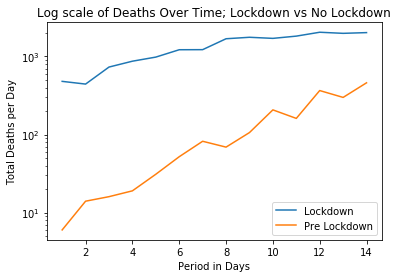

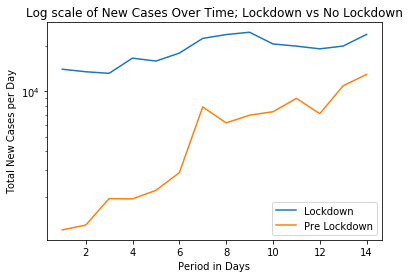

In [26]:
plt.yscale('log')
plt.plot(test_data[test_data['Lockdown'] == True].groupby(['Date Count'])['deaths'].sum(), label='Lockdown')
plt.plot(test_data[test_data['Lockdown'] == False].groupby(['Date Count'])['deaths'].sum(), label='Pre Lockdown')
plt.title('Log scale of Deaths Over Time; Lockdown vs No Lockdown')
plt.ylabel('Total Deaths per Day')
plt.xlabel('Period in Days')
plt.legend()
plt.show()

plt.yscale('log')
plt.plot(test_data[test_data['Lockdown'] == True].groupby(['Date Count'])['cases'].sum(), label='Lockdown')
plt.plot(test_data[test_data['Lockdown'] == False].groupby(['Date Count'])['cases'].sum(), label='Pre Lockdown')
plt.title('Log scale of New Cases Over Time; Lockdown vs No Lockdown')
plt.ylabel('Total New Cases per Day')
plt.xlabel('Period in Days')
plt.legend()
plt.show()

This graph makes it clear that even though the spread of the disease is still exponentially increasing, the slope of the lockdown period is much less steep than the slope of the period before lockdown. This indicates that the actual exponential rate of increase has gone down even if the raw number of deaths between the groups is higher in the lockdown group.

The reason the total number of deaths between plotted groups don't have overlap is because the two groups being compared are really the same experimental group being observed at two points in time. The log scales flatten the the exponential curves so that the slopes can be compared to see differences in rates of exponential growth rather than directly comparing the total cases and deaths per day.

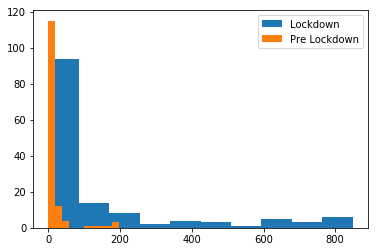

Lockdown:
DescribeResult(nobs=140, minmax=(0, 849), mean=135.52142857142857, variance=52458.52471736896, skewness=1.910233624536419, kurtosis=2.4466081076549937)
Shapiro W: 0.6403763294219971
Shapiro p-value: 5.154454887882514e-17


Pre Lockdown:
DescribeResult(nobs=138, minmax=(0, 196), mean=13.681159420289855, variance=1326.1457738284146, skewness=3.7586227619432084, kurtosis=13.868720410081227)
Shapiro W: 0.4155004024505615
Shapiro p-value: 3.858557642870491e-21


In [27]:
plt.hist(test_data[test_data['Lockdown'] == True]['deaths'], label='Lockdown')
plt.hist(test_data[test_data['Lockdown'] == False]['deaths'], label='Pre Lockdown')
plt.legend()
plt.show()

lock_shapiro = stats.shapiro(test_data[test_data['Lockdown'] == True]['deaths'])
prelock_shapiro = stats.shapiro(test_data[test_data['Lockdown'] == False]['deaths'])


print('Lockdown:')
print(stats.describe(test_data[test_data['Lockdown'] == True]['deaths']))
print('Shapiro W: {}'.format(lock_shapiro[0]))
print('Shapiro p-value: {}'.format(lock_shapiro[1]))
print('\n')
print('Pre Lockdown:')
print(stats.describe(test_data[test_data['Lockdown'] == False]['deaths']))
print('Shapiro W: {}'.format(prelock_shapiro[0]))
print('Shapiro p-value: {}'.format(prelock_shapiro[1]))


 With p-values well below .05 and W scores far from 1, the data is concluded to be non-normally distributed, so a normal ttest cant be used

## Null Hypothesis:

### The null hypothesis is that the median difference between pairs of observations (deaths over time while under lockdown vs not under lockdown) is zero

In [28]:
# Wilcoxon test used because the data is non-normally distributed and all datasets experienced both A/B version of the test
# (in this case it is whether going into lockdown had an effect on rates of death)
stats.wilcoxon((test_data[test_data['Lockdown'] == True]['deaths']-test_data[test_data['Lockdown'] == False]['deaths']))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2781: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2782: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


WilcoxonResult(statistic=0.0, pvalue=2.418014348569743e-47)

### The pvalue is incredibly low which means we can reject the null hypothesis and that the median difference between pairs of observations is significantly different from zero

In [30]:
median_deaths = test_data['deaths'].median()
median_cases = test_data['cases'].median()
mean_pop = test_data['popData2018'].mean()
death_per_case = median_deaths / median_cases
cases_per_pop = median_cases / mean_pop
print('Median deaths per median positive cases: {}'.format(death_per_case))
print('Median positve cases per average population: {}'.format(cases_per_pop))

Median deaths per median positive cases: 0.010067114093959731
Median positve cases per average population: 1.1164574791142332e-05


# To summarize:
Even if there was a slowdown in number of deaths per day by COVID-19, there wasn't enough to cause the raw rate of deaths to decrease over time. This means lockdowns alone aren't enough to stop the exponential nature of the curve, but when the curves are shown on a log scale, the differences in their slopes (death rates of countries going into lockdown vs the period just before) indicate lockdowns have a noticeable impact on the actual rate of spread. To see the actual effectiveness of the lockdowns, further tests can be compared to those countries just upon re-opening (when all of those countries actually do re-open). If given more time, different date ranges could be compared or the countries could be compared individually to see if the results are similar enough to verify the general trend. 

This information could be useful to lawmakers when determining whether or not they should continue to enforce lockdown procedures. As more countries decide to test the waters and release their lockdown procedures in the midst of the pandemic, those groups can be compared further to either refute or verify these first trends. Though, from the data gathered so far, it can be safely concluded the lockdowns show a strong correlation with a slowed exponential rate of spread when compared against those same countries before they went into lockdown.